In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.ops import deform_conv2d
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Loading FashionMNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.ToTensor()            # Convert to tensor
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

### Preparing data for training with DataLoaders

In [3]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### ResNet18 Model Definition – Dilated Convolution

In [4]:
# Replace standard 3x3 convolution with dilated conv
def conv3x3(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=2, dilation=2,  bias=False)

# 1x1 standard convolution remains unchanged
def conv1x1(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)  # Grayscale input
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], norm_layer, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], norm_layer, stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], norm_layer, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, norm_layer, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion),
                norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, norm_layer)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def resnet18_dilated(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [5]:
model = resnet18_dilated(num_classes=10)

# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 11175370
Trainable parameters: 11175370


### Model Training

In [6]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
# Initialize and train the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = resnet18_dilated(num_classes=10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
earlystopper = EarlyStopper()

In [8]:
# Training function
def train(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    loss /= total
    acc = 100.0 * correct / total
    return loss, acc

In [9]:
best_val_acc = 0.0 
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train for several epochs
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion)
    
    # Store the values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "resnet18_dilated_fashionmnist.pth")
        print(f"Best model saved at epoch {epoch} with Val Acc: {val_acc:.2f}%")
    
    if earlystopper.early_stop(val_loss):
        break

[Epoch 1] Train Loss: 0.4397 | Train Acc: 84.12% | Val Loss: 0.3435 | Val Acc: 88.00%
Best model saved at epoch 1 with Val Acc: 88.00%


[Epoch 2] Train Loss: 0.2711 | Train Acc: 90.34% | Val Loss: 0.3731 | Val Acc: 87.10%


[Epoch 3] Train Loss: 0.2321 | Train Acc: 91.62% | Val Loss: 0.3029 | Val Acc: 89.20%
Best model saved at epoch 3 with Val Acc: 89.20%


[Epoch 4] Train Loss: 0.2084 | Train Acc: 92.53% | Val Loss: 0.2792 | Val Acc: 90.11%
Best model saved at epoch 4 with Val Acc: 90.11%


[Epoch 5] Train Loss: 0.1894 | Train Acc: 93.22% | Val Loss: 0.2469 | Val Acc: 91.35%
Best model saved at epoch 5 with Val Acc: 91.35%


[Epoch 6] Train Loss: 0.1759 | Train Acc: 93.74% | Val Loss: 0.2282 | Val Acc: 91.83%
Best model saved at epoch 6 with Val Acc: 91.83%


[Epoch 7] Train Loss: 0.1613 | Train Acc: 94.19% | Val Loss: 0.2270 | Val Acc: 91.83%


[Epoch 8] Train Loss: 0.1521 | Train Acc: 94.52% | Val Loss: 0.2441 | Val Acc: 91.29%


[Epoch 9] Train Loss: 0.1419 | Train Acc: 94.89% | Val Loss: 0.2141 | Val Acc: 92.59%
Best model saved at epoch 9 with Val Acc: 92.59%


[Epoch 10] Train Loss: 0.1302 | Train Acc: 95.40% | Val Loss: 0.2093 | Val Acc: 92.50%


[Epoch 11] Train Loss: 0.1196 | Train Acc: 95.70% | Val Loss: 0.2261 | Val Acc: 92.10%


[Epoch 12] Train Loss: 0.1115 | Train Acc: 96.00% | Val Loss: 0.2318 | Val Acc: 91.89%


[Epoch 13] Train Loss: 0.0999 | Train Acc: 96.46% | Val Loss: 0.2745 | Val Acc: 91.45%


### Print Classification Results

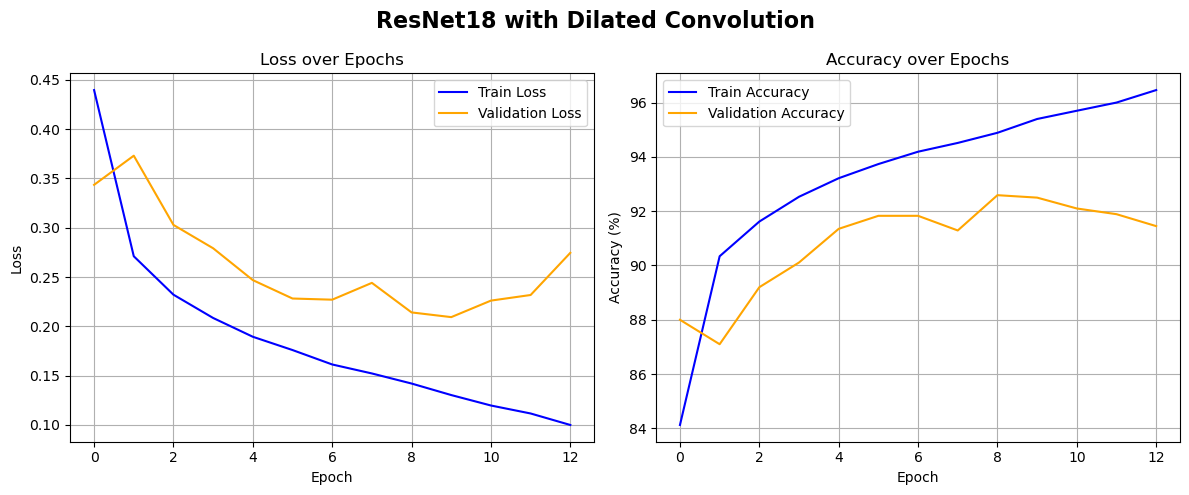

In [10]:
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle("ResNet18 with Dilated Convolution", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


In [12]:
# Load Best Model from checkpoint
model = torch.load("resnet18_dilated_fashionmnist.pth", weights_only=False)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [13]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report_Dilated Convolution:")
print(classification_report(all_labels, all_preds, digits=4))



Classification Report_Dilated Convolution:
              precision    recall  f1-score   support

           0     0.8800    0.8870    0.8835      1000
           1     0.9959    0.9830    0.9894      1000
           2     0.9655    0.8120    0.8821      1000
           3     0.9122    0.9460    0.9288      1000
           4     0.9023    0.8870    0.8946      1000
           5     0.9726    0.9940    0.9832      1000
           6     0.7390    0.8380    0.7854      1000
           7     0.9516    0.9840    0.9676      1000
           8     0.9821    0.9900    0.9861      1000
           9     0.9915    0.9380    0.9640      1000

    accuracy                         0.9259     10000
   macro avg     0.9293    0.9259    0.9265     10000
weighted avg     0.9293    0.9259    0.9265     10000



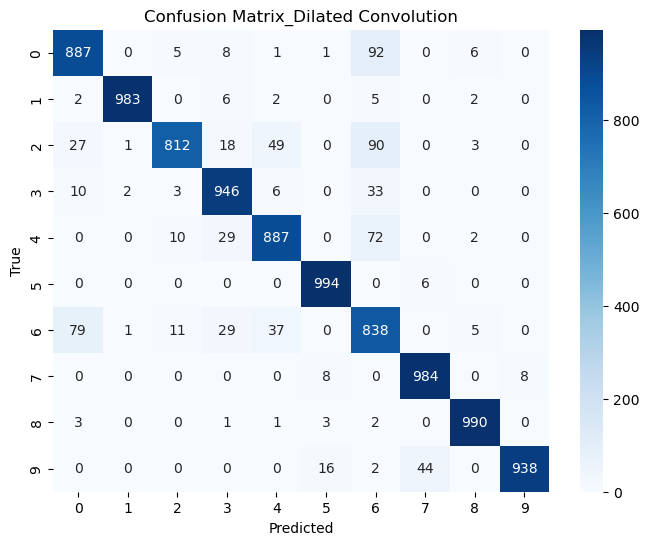

In [14]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix_Dilated Convolution")
plt.show()